# Steinmetz dataset analysis
I want to test if PFC-HPC coherence reflects global synchrony across distributed brain structures

This was done to test the idea that PFC-HPC theta coherence reflects global synchronization, rather than a select group of structures being synchronized

To make these analysis tractable, we will perform a subsampling procedure, calculate coherence pairwise, then compute correlations

The code here is purposefully designed to not come with any sort of package of custom functions/classes aside from what is written in this notebook. Please check the "Environment" below and download the required packages to work this code.
___

Environment:
    `pip install numpy scipy matplotlib pandas ipykernel pynwb`
___


Downloads:

Most of the data: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406
    
LFP data: https://figshare.com/articles/dataset/LFP_data_from_Steinmetz_et_al_2019/9727895

NWB data: https://figshare.com/articles/dataset/Datasets_from_Steinmetz_et_al_2019_in_NWB_format/11274968/1 

___

Instructions after downloading/setting up environment:

You have to unzip the .tar file and move things around. You must move all data into one directory. This includes the NWB data, LFP data and spike data.

___


### Import what you need

In [1]:
import tarfile
import numpy as np
import os
import matplotlib.pyplot as plt
from pynwb import NWBHDF5IO, NWBFile
from scipy.interpolate import interp1d

### Helper functions

In [3]:
"""
# define pathname
pathname = "/Users/js0403/steinmetz_data/allData/Richards_2017-10-31"

# autopopulate the rest
dir_contents = sorted(os.listdir(pathname))
lfp_filenames = [i for i in dir_contents if 'bin' in i]
nwb_filenames = [i for i in dir_contents if 'nwb' in i]
lfptimes_filenames = [i for i in dir_contents if 'lf.timestamps.npy' in i]
#probe_sites = np.load(os.path.join(pathname,"probes.sitePositions.npy"))

# load probe site information
lfp_time_blocks = []
for i in lfptimes_filenames:
    lfp_time_blocks.append(np.load(os.path.join(pathname,i)))

# interpolate times within a probe 
# VALIDATED in MATLAB on 10/26 to have same shape and almost exactly the same values. There are subtle differences at the .00000000000001 scale
# and this difference is not always present. Generally, the data are the same.
#     >> tsData = readNPY('...lf.timestamps.npy');
#     >> allTS = interp1(tsData(:,1), tsData(:,2), tsData(1,1):tsData(2,1));
#     Validation required the following download: https://github.com/kwikteam/npy-matlab/tree/master
lfp_times = []
for i in range(len(lfp_time_blocks)):
    # note that i organizes the probe
    newx = np.arange(lfp_time_blocks[i][0][0],lfp_time_blocks[i][1][0]+1) # get vectorized and linear change between these times
    x = (lfp_time_blocks[i][0][0], lfp_time_blocks[i][1][0]) # x times are the start and end of first column
    y = (lfp_time_blocks[i][0][1], lfp_time_blocks[i][1][1]) # y times are the start and end of second column
    lfp_times.append(interp1d(x,y)(newx))
"""

In [2]:
def multi_plotter(data, time_range, fs):
    idx = [int(time_range[0]*fs),int(time_range[1]*fs)]
    color='k'
    fig, axes = plt.subplots(nrows=data.shape[0],ncols=1)
    for i in range(data.shape[0]):
        if i == data.shape[0]-1:
            x_data = np.linspace(time_range[0],time_range[1],int(fs*(time_range[1]-time_range[0])))
            axes[i].plot(x_data, data[i,idx[0]:idx[1]],color,linewidth=0.75)
            axes[i].set_xlabel("Time (sec)")
        else:
            axes[i].plot(data[i,idx[0]:idx[1]],color,linewidth=0.75)
            #axes[i].xlabel("Time (sec)")
    fig.show()

# some general helper functions for nwb stuff
def read_nwb(pathname: str):
    """
        Read NWB files

        Args:
            nwbpath: path directly to the nwb file
    """
    lfp_names, nwb_names = unpack_paths(pathname=pathname)
    io = NWBHDF5IO(nwbpath, mode="r")
    nwb_file = io.read()

    return nwb_file

def load_data(pathname: str):

    """
    this function loads LFP data, LFP times, and the NWB file

    Args:
        >>> pathname: string directory with data
    Returns:
        >>> lfp_data: list of LFP data unpacked from the .tar files
        >>> lfp_times: list of LFP times interpolated to match the LFP. 
                    *** NOTE: different probes are temporally offset and so you need to center it
                                using a timestamp and extracting datapoints around that point to 
                                temporarily align the data if comparing between probes
        >>> nwb_data: list of nwb files
    """

    # define pathname
    #pathname = "/Users/js0403/steinmetz_data/allData/Richards_2017-10-31"

    # autopopulate the rest
    dir_contents = sorted(os.listdir(pathname))
    lfp_filenames = [i for i in dir_contents if 'bin' in i]
    nwb_filenames = [i for i in dir_contents if 'nwb' in i]
    lfptimes_filenames = [i for i in dir_contents if 'lf.timestamps.npy' in i]

    #%%  -- load LFP times and interpolate timestamps -- #%%

    # load probe site information
    lfp_time_blocks = []
    for i in lfptimes_filenames:
        lfp_time_blocks.append(np.load(os.path.join(pathname,i)))

    # interpolate times within a probe 
    # VALIDATED in MATLAB on 10/26 to have same shape and almost exactly the same values. There are subtle differences at the .00000000000001 scale
    # and this difference is not always present. Generally, the data are the same.
    #     >> tsData = readNPY('...lf.timestamps.npy');
    #     >> allTS = interp1(tsData(:,1), tsData(:,2), tsData(1,1):tsData(2,1));
    #     Validation required the following download: https://github.com/kwikteam/npy-matlab/tree/master
    lfp_times = []
    for i in range(len(lfp_time_blocks)):
        # note that i organizes the probe
        newx = np.arange(lfp_time_blocks[i][0][0],lfp_time_blocks[i][1][0]+1) # get vectorized and linear change between these times
        x = (lfp_time_blocks[i][0][0], lfp_time_blocks[i][1][0]) # x times are the start and end of first column
        y = (lfp_time_blocks[i][0][1], lfp_time_blocks[i][1][1]) # y times are the start and end of second column
        lfp_times.append(interp1d(x,y)(newx))

    # get LFP data
    lfp_data = []
    for i in lfp_filenames:
        with open(os.path.join(pathname,i), 'rb') as fid:
            lfp_data.append(np.fromfile(fid, np.int16).reshape((-1,385)).T) # was 385 

    # nwb_file
    nwb_data = []
    for i in nwb_filenames:
        io = NWBHDF5IO(os.path.join(pathname,i), mode="r")
        nwb_data.append(io.read())

    return lfp_data, lfp_times, nwb_data

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx


### Load data

**Note that np.fromfile approach shown below was validated by performing the recommended procedures in matlab

In [3]:
# define pathname
pathname = "/Users/js0403/steinmetz_data/allData/Richards_2017-10-31"
lfp_data, lfp_times, nwb_data = load_data(pathname=pathname)

/Users/js0403/anaconda3/envs/griffin/lib/python3.9/site-packages/pynwb/base.py:193: UserWarning: IntervalSeries 'wheel_moves': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "


### Probe data shape
Notice that the two probes have temporal disalignment and even show different timestamp counts. This has to be accounted for.

In [4]:
print("Legend: lfp_data row = channel, column = samples; lfp_times row = timestamp")
print()
print("Probe0 lfp_data shape:", lfp_data[0].shape, "lfp_times shape:",lfp_times[0].shape)
print("Probe1 lfp_data shape:", lfp_data[1].shape, "lfp_times shape:",lfp_times[1].shape)

Legend: lfp_data row = channel, column = samples; lfp_times row = timestamp

Probe0 lfp_data shape: (385, 7416944) lfp_times shape: (7416944,)
Probe1 lfp_data shape: (385, 7416292) lfp_times shape: (7416292,)


### Plot example data
Note that the final value is to be excluded. Anything with "root" is not included. It is probably some sort of reference or something.

Text(0.5, 1.0, 'Probe1, Final Channel - Reference?')

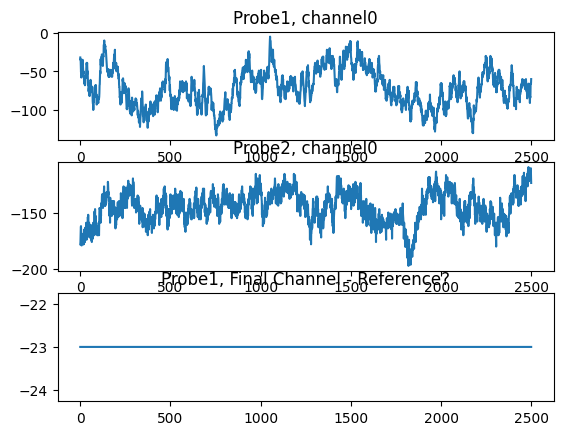

In [5]:
# probe 1 channel 0
plt.subplot(311)
plt.plot(lfp_data[0][0,0:2500])
plt.title("Probe1, channel0")

# probe 2 channel 0 
plt.subplot(312)
plt.plot(lfp_data[1][0,0:2500])
plt.title("Probe2, channel0")

# probe 1, final channel
plt.subplot(313)
plt.plot(lfp_data[0][384,0:2500])
plt.title("Probe1, Final Channel - Reference?")

/var/folders/f3/11w5x6bs32gd1xc4lh41qdnr0000gp/T/ipykernel_47561/2594915684.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


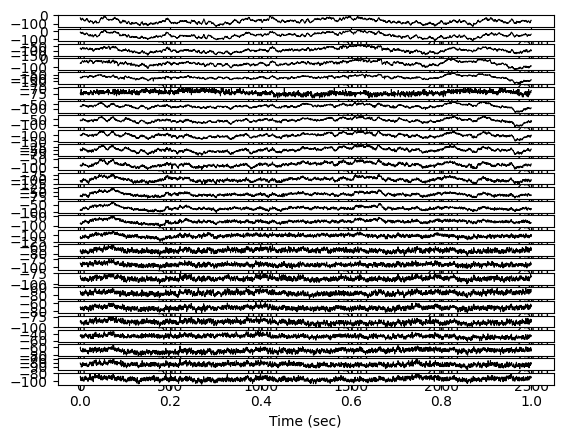

In [8]:
data = lfp_data[0][0::15,:]; # Get data from every other 15 channels
time_range = [0, 1]; # time range to use (in sec)
fs = 2500 # sampling rate
multi_plotter(data=data,time_range=[0,1],fs=2500)

### Using the NWB file, get brain areas

I can't seem to find the timestamps. There is a timeshift between probes. I think I'll just stick to within probe analyses

In [122]:
# there is only 1 NWB file
nwb_data[0]

root pynwb.file.NWBFile at 0x22689809840
Fields:
  acquisition: {
    lickPiezo <class 'pynwb.base.TimeSeries'>,
    wheel_position <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    0 <class 'pynwb.device.Device'>,
    1 <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    Probe1 <class 'pynwb.ecephys.ElectrodeGroup'>,
    Probe2 <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Large-scale Neuropixels recordings across brain regions of mice during a head-fixed visual discrimination task. 
  experimenter: ['Nick Steinmetz']
  file_create_date: [datetime.datetime(2019, 11, 26, 14, 42, 15, 565060, tzinfo=tzoffset(None, -28800))]
  identifier: Richards_2017-10-31
  institution: University College London
  intervals: {
    spontaneous <class 'pynwb.epoch.TimeIntervals'>,
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  keywords: <StrDataset for HDF5 dataset "keywords": shape (7,), type "|O">
  lab: The Carandini and Harris Lab
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>
  }
  related_publications: ['DOI 10.1038/s41586-019-1787-x']
  session_description: Neuropixels recording during visual discrimination in awake mice.
  session_start_time: 2017-10-31 12:00:00+00:00
  stimulus: {
    passive_beeps <class 'pynwb.base.TimeSeries'>,
    passive_click_times <class 'pynwb.base.TimeSeries'>,
    passive_left_contrast <class 'pynwb.base.TimeSeries'>,
    passive_right_contrast <class 'pynwb.base.TimeSeries'>,
    passive_white_noise <class 'pynwb.base.TimeSeries'>,
    receptive_field_mapping_sparse_noise <class 'pynwb.base.TimeSeries'>
  }
  subject: subject pynwb.file.Subject at 0x22689808688
Fields:
  age: 182 days
  description: strain: C57Bl6/J
  genotype: C57BL/6J
  sex: M
  species: Mus musculus

  timestamps_reference_time: 2017-10-31 12:00:00+00:00
  trials: trials <class 'pynwb.epoch.TimeIntervals'>
  units: units <class 'pynwb.misc.Units'>

In [73]:
# complicated indexing of the dataframe to get indices
#df_by_probe[0][df_by_probe[0].location=='root'].site_id

id
220    225
221    226
222    228
223    229
224    230
      ... 
369    378
370    380
371    381
372    382
373    383
Name: site_id, Length: 154, dtype: int32

In [69]:
"""
brain_area_probe = [np.unique(df_by_probe[i].location).tolist() for i in range(len(df_by_probe))]
for i in range(len(brain_area_probe)):
    brain_area_probe[i].remove('root')
brain_area_probe
"""

[['MOs', 'OLF', 'ORB'], ['MRN', 'PAG', 'RSP', 'SCm', 'SCs']]

In [6]:
# convert to dataframe
df = nwb_data[0].electrodes.to_dataframe()

# split by probe
probe_list = np.unique(df.group_name).tolist()
df_by_probe = [df[df.group_name==i] for i in probe_list] # list grouped by probe ID

# get brain areas per probe
brain_area_probe = [np.unique(df_by_probe[i].location).tolist() for i in range(len(df_by_probe))]
for i in range(len(brain_area_probe)):
    brain_area_probe[i].remove('root')

brain_probe_idx = []
for i in range(len(brain_area_probe)):
    # index of brain areas to refer back to channels
    brain_idx = dict()
    for bi in brain_area_probe[i]:
        brain_idx[bi] = df_by_probe[i][df_by_probe[i].location==bi].site_id.tolist() # get indices where brain_areas == i
    brain_probe_idx.append(brain_idx)
print("brain_probe_idx tells us the channel location for a brain structure per probe. brain_probe_idx[0] is probe 1")

brain_probe_idx tells us the channel location for a brain structure per probe. brain_probe_idx[0] is probe 1


In [7]:
brain_probe_idx[1].keys()

dict_keys(['MRN', 'PAG', 'RSP', 'SCm', 'SCs'])

### Lets group the data together by brain structure, organized by probe

In [8]:
brain_area_probe[0][0]

'MOs'

In [9]:
#lfp_data[i][brain_probe_idx[i][braini],:]
i=0
braini = brain_area_probe[i][0]
idx = np.array(brain_probe_idx[i][braini])
indexdeLFP = np.mean(lfp_data[i][idx,:],axis=0)
indexdeLFP.shape

(7416944,)

In [29]:
idx

array([30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
       65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81])

In [13]:
i=1; braini = 'PAG'; idx = np.array([brain_probe_idx[i][braini]])[0]
lfp_data[i][idx].shape

(90, 7416292)

In [20]:
del probe_brain_lfp

In [10]:
# create an embedded dictionary containing probe1/probe2 and brain structure data
probe_brain_lfp = []
for i in range(len(lfp_data)):
    for braini in brain_area_probe[i]: # a loop across probes and brain structure items
        # brain structure index
        #brain_probe_idx[i]
        print("probe",i,braini,"first channel:",brain_probe_idx[i][braini][0])

        # get index of channels
        idx = np.array([brain_probe_idx[i][braini]])[0]
        #print(idx)
        probe_brain_lfp.append(np.mean(lfp_data[i][idx,:],axis=0)) # mean over channels from the same structure

"""
probe1_lfp = lfp_data[0]
probe1_brain_idx = brain_probe_idx[0]

probe1_lfp_brain = dict()
for i in probe1_brain_idx.keys():
    idx = probe1_brain_idx[i]
    print(i, "index:",idx)
"""

probe 0 MOs first channel: 113
probe 0 OLF first channel: 0
probe 0 ORB first channel: 20
probe 1 MRN first channel: 30
probe 1 PAG first channel: 82
probe 1 RSP first channel: 318
probe 1 SCm first channel: 174
probe 1 SCs first channel: 250


'\nprobe1_lfp = lfp_data[0]\nprobe1_brain_idx = brain_probe_idx[0]\n\nprobe1_lfp_brain = dict()\nfor i in probe1_brain_idx.keys():\n    idx = probe1_brain_idx[i]\n    print(i, "index:",idx)\n'

### get random times, then extract 1.25s of LFP around that event. Compute cross coherence.

Because the flattened arrays are of different size (temporal offsets in sampling), we just gotta keep the data format as list of arrays
___

First, lets randomly sample timestamps and then get nearest times to the second probe. This isn't exact, but the systematic error will always be consistent and so it's not quite as much an error for this analysis as it is an annoyance as I won't be linking anything to behavior
___

Below, I show the temporal alignment of probe times based on times from probe0. I can then use `index` to get `lfp_data[0]` and `index1` to get `lfp_data[1]`

In [65]:
fs = 2500
# 50 random samples
n = 50 
# get index
index = np.random.choice(lfp_times[0].shape[0]-fs, n, replace=False)  
# probe0 times
probe0_times = lfp_times[0][index]
# probe1 times
probe1_times = np.zeros(probe0_times.shape); index1 = np.zeros(probe0_times.shape)
for i in range(len(probe0_times)): # i represents probe0_times iteratively
    p1ts, idx1 = find_nearest(lfp_times[1],probe0_times[i]) # nearest probe times in probe0 to probe1 for alignment
    probe1_times[i]=p1ts
    index1[i]=idx1

#### MORE Proof of concept for temporal alignment - DONT DELETE, JOHN - 

[ 485.0580654   138.77321871  407.26405491 2090.94268191 2649.64155724
 2095.15228248  992.19813377  692.56249338 1633.68822026   25.01040337
 1696.35102871 1202.38456211 2581.68354808 1516.90500452 1848.01384916
  197.75442666 1905.69385694 2438.44672877 1801.16424284  748.16730087
 1767.72023834 2675.66596075 2462.51393201 2639.75795591 1616.53061795
 1790.10864135 2646.3859568  2337.40711514 2225.48030005 1691.01262799
 1634.09142032  164.25162215 1576.8770126  2449.71993029 2087.63068147
 1912.62785787 1657.93862353 1666.5982247  2243.89390254  493.82486658
  271.4476366  2879.11438818 2425.49392702  470.86966349 2187.61789495
  868.98051716 1915.7886583  1251.93016879 1964.04506481  195.0984263 ]
[ 485.05819129  138.77335327  407.2642233  2090.94258755 2649.64163034
 2095.15220746  992.1981902   692.56237284 1633.68802461   25.01041514
 1696.35112102 1202.38438443 2581.68370888 1516.9050722  1848.01383843
  197.75443227 1905.69371127 2438.44663133 1801.16441682  748.16743587
 1767

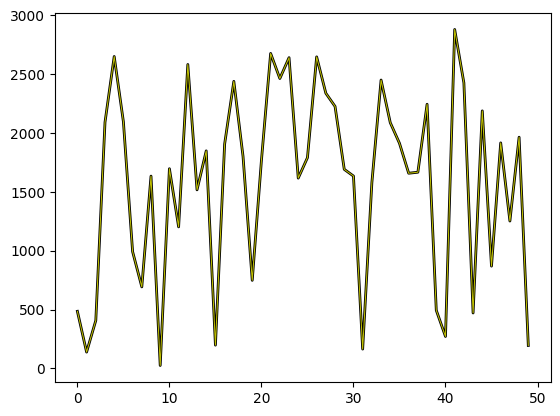

In [67]:
# -- Proof of concept -- # -- DONT DELETE -- #
# probe1_times, index1 = find_nearest(lfp_times[1],probe0_times[0])
# print('probe0 sample0:',probe0_times[0])
# print('probe1 sample0:',probe1_times)

plt.plot(probe0_times,color='k',linewidth=2)
plt.plot(probe1_times,color='y',linewidth=0.75)
print(probe0_times)
print(probe1_times)

### Get LFP data

In [70]:
index

array([1212645,  346933, 1018160, 5227356, 6624103, 5237880, 2480495,
       1731406, 4084220,   62526, 4240877, 3005961, 6454208, 3792262,
       4620034,  494386, 4764234, 6096116, 4502910, 1870418, 4419300,
       6689164, 6156284, 6599394, 4041326, 4475271, 6615964, 5843517,
       5563700, 4227531, 4085228,  410629, 3942192, 6124299, 5219076,
       4781569, 4144846, 4166495, 5609734, 1234562,  678619, 7197785,
       6063734, 1177174, 5469044, 2172451, 4789471, 3129825, 4910112,
        487746])

In [79]:
index

array([1212645,  346933, 1018160, 5227356, 6624103, 5237880, 2480495,
       1731406, 4084220,   62526, 4240877, 3005961, 6454208, 3792262,
       4620034,  494386, 4764234, 6096116, 4502910, 1870418, 4419300,
       6689164, 6156284, 6599394, 4041326, 4475271, 6615964, 5843517,
       5563700, 4227531, 4085228,  410629, 3942192, 6124299, 5219076,
       4781569, 4144846, 4166495, 5609734, 1234562,  678619, 7197785,
       6063734, 1177174, 5469044, 2172451, 4789471, 3129825, 4910112,
        487746])

In [95]:
# make a empty list of size n, with size of brain regions x fs
#[[np.zeros(shape=[8,2500])] for i in range(n)]
probe_brain_lfp[0].shape

(7416944,)

In [96]:
fs = 2500
idxAround = fs/2
lfp0_rs = [ [np.zeros(shape=[len(probe_brain_lfp),fs])] for i in range(n) ] # n lists with size brain-num X fs

for i in range(len(lfp0_rs)): # per each iteration; loop over n iterations, represented by empty lists
    for braini in range(len(probe_brain_lfp)): # loop over brain structures
        for idxi in index: # loop over index
            idx = np.arange(idxi,idxi+2500)
            #probe_brain_lfp[braini][idxi]
            print(idx)




"""
for braini in range(len(probe_brain_lfp)):
    lfp0_rs.append(np.zeros(len(probe_brain_lfp),fs))
    for i in range(len(index)): # loop over the randomly sampled indices
        idx = np.arange(index[i],index[i]+fs) # create a vectorized index from index, i, to i+fs samples
        lfp0_rs[i]=probe_brain_lfp[braini][idx]
        #lfp0_rs.append(probe_brain_lfp[braini][probe_brain_lfp[braini][i]:probe_brain_lfp[braini][i]+fs])
        """

[1212645 1212646 1212647 ... 1215142 1215143 1215144]
[346933 346934 346935 ... 349430 349431 349432]
[1018160 1018161 1018162 ... 1020657 1020658 1020659]
[5227356 5227357 5227358 ... 5229853 5229854 5229855]
[6624103 6624104 6624105 ... 6626600 6626601 6626602]
[5237880 5237881 5237882 ... 5240377 5240378 5240379]
[2480495 2480496 2480497 ... 2482992 2482993 2482994]
[1731406 1731407 1731408 ... 1733903 1733904 1733905]
[4084220 4084221 4084222 ... 4086717 4086718 4086719]
[62526 62527 62528 ... 65023 65024 65025]
[4240877 4240878 4240879 ... 4243374 4243375 4243376]
[3005961 3005962 3005963 ... 3008458 3008459 3008460]
[6454208 6454209 6454210 ... 6456705 6456706 6456707]
[3792262 3792263 3792264 ... 3794759 3794760 3794761]
[4620034 4620035 4620036 ... 4622531 4622532 4622533]
[494386 494387 494388 ... 496883 496884 496885]
[4764234 4764235 4764236 ... 4766731 4766732 4766733]
[6096116 6096117 6096118 ... 6098613 6098614 6098615]
[4502910 4502911 4502912 ... 4505407 4505408 4505409

'\nfor braini in range(len(probe_brain_lfp)):\n    lfp0_rs.append(np.zeros(len(probe_brain_lfp),fs))\n    for i in range(len(index)): # loop over the randomly sampled indices\n        idx = np.arange(index[i],index[i]+fs) # create a vectorized index from index, i, to i+fs samples\n        lfp0_rs[i]=probe_brain_lfp[braini][idx]\n        #lfp0_rs.append(probe_brain_lfp[braini][probe_brain_lfp[braini][i]:probe_brain_lfp[braini][i]+fs])\n        '

In [60]:
2500/2

1250.0